### Классификация текста

Одной из широко используемых задач NLP в различных бизнес-задачах является “классификация текста”. Цель классификации текста состоит в том, чтобы автоматически классифицировать текстовые документы по одной или нескольким определенным категориям. Некоторые примеры классификации текста:
- Определенеие настроений аудитории из социальных сетей
- Обнаружение спама и нежелательных писем
- Автоматическая маркировка запросов клиентов
- Категоризация новостных статей по определенным темам

Классификация текста является примером задачи машинного обучения с учителем, поскольку для обучения классификатора используется помеченный набор данных, содержащий текстовые документы и их метки. Пайплайн классификации текста состоит из 4 основных частей:
1. Подготовка данных
2. Генерация признаков
3. Тренировка модели
4. Оценка и тьюнинг модели

Проделаем данные шаги.

In [18]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
data = pd.read_excel("./data/summer.xls")

#### Предобработка текста

Сделаем некоторую базовую предобработку текста

In [19]:
from pymorphy2 import MorphAnalyzer
# from stop_words import get_stop_words
from string import punctuation
from nltk.corpus import stopwords

exclude = set(punctuation)
sw =  stopwords.words("russian")[1:50]
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3

In [20]:
data

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,True
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целое удобноной приложениеиз минус хотеть сл...,True
2,5,Отлично все,2017-08-14,отлично всё,True
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать на 1 работа антивирус далёкий н...,True
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,True
...,...,...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,ну и шляпас роот право бесполезный прогаразраб...,False
20655,5,Ок,2017-06-01,около,True
20656,4,Доволен,2017-06-01,довольный,True
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,песопаснастя рута ни нужын,False


In [21]:
from sklearn import model_selection, preprocessing
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['text'], data['target'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [6]:
count_vect = CountVectorizer().fit(train_x.values)
xtrain_count = count_vect.transform(train_x)
xvalid_count = count_vect.transform(valid_x)

tfidf_vec = TfidfVectorizer().fit(train_x.values)
xtrain_tfidf = tfidf_vec.transform(train_x)
xvalid_tfidf = tfidf_vec.transform(valid_x)

tfidf_vec_ngrams = TfidfVectorizer(ngram_range=(1, 3)).fit(train_x.values)
xtrain_tfidf_ngram = tfidf_vec.transform(train_x)
xvalid_tfidf_ngram = tfidf_vec.transform(valid_x)



#### Построение моделей

Последний шаг в процессе классификации текста - это обучение классификатора с использованием признаков, созданных на предыдущем шаге. Опробуем несколько вариантов моделей машинного обучения.

In [7]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

##### Naive Bayes

Наивный Байес - это метод классификации, основанный на теореме Байеса с допущением независимости между предикторами. Наивный байесовский классификатор предполагает, что наличие определенного признака в классе не связано с наличием какого-либо другого признака в нем.

In [8]:
from sklearn import naive_bayes, linear_model, ensemble, metrics, svm

In [9]:
# Naive Bayes на Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes на Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes на Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

NB, Count Vectors:  0.9274863277293903
NB, WordLevel TF-IDF:  0.9173587198703667
NB, N-Gram Vectors:  0.9173587198703667


 ##### Linear Classifier (Логистическая регрессия)
 
Логистическая регрессия измеряет связь между категориальной зависимой переменной и одной или несколькими независимыми переменными путем оценки вероятностей, используя логистическую/сигмоидную функцию. 

In [10]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier на Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

LR, Count Vectors:  0.9205995543852542
LR, WordLevel TF-IDF:  0.9232327324286004
LR, N-Gram Vectors:  0.9232327324286004


##### SVM

SVM -  алгоритм машинного обучения с учителем, который может быть использован как для классификации, так и для регрессии. Модель извлекает наилучшую возможную гиперплоскость/линию, которая разделяет эти два класса.

In [11]:
# SVM на Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)


SVM, N-Gram Vectors:  0.9297144014583756


##### RandomForest

Cлучайный лес - ансамбль решающих деревьев.

In [12]:
from tqdm import tqdm_notebook

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[]

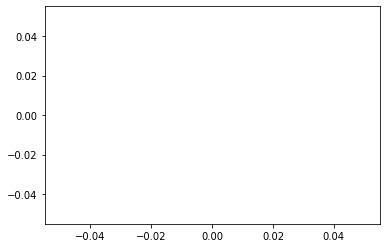

In [14]:
plt.plot()

In [15]:
clf = ensemble.RandomForestClassifier(n_estimators=10000).fit(xtrain_count, train_y)

In [16]:
acs = []
for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):
    clf = ensemble.RandomForestClassifier(n_estimators=i).fit(xtrain_count, train_y)
    acs.append(metrics.accuracy_score(clf.predict(xvalid_count), valid_y))
    

<ipython-input-16-3ade24eef699>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):


  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# RF на Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF на Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)


RF, Count Vectors:  0.918371480656269
RF, WordLevel TF-IDF:  0.922219971642698


##### Boosting Model

Бустинг - процедура последовательного построения композиции алгоритмов машинного обучения, когда каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

In [28]:
# Extereme Gradient Boosting на Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting на Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

NameError: name 'xgboost' is not defined